In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pd.set_option('display.max_columns', None)
training_set_features = pd.read_csv('training_set_features.csv')
training_set_labels = pd.read_csv('training_set_labels.csv')
test_set_features = pd.read_csv('test_set_features.csv')
training_set_features.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [182]:
training_set_features.shape

(26707, 36)

In [183]:
training_set_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   xyz_concern                  26615 non-null  float64
 2   xyz_knowledge                26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_xyz              24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

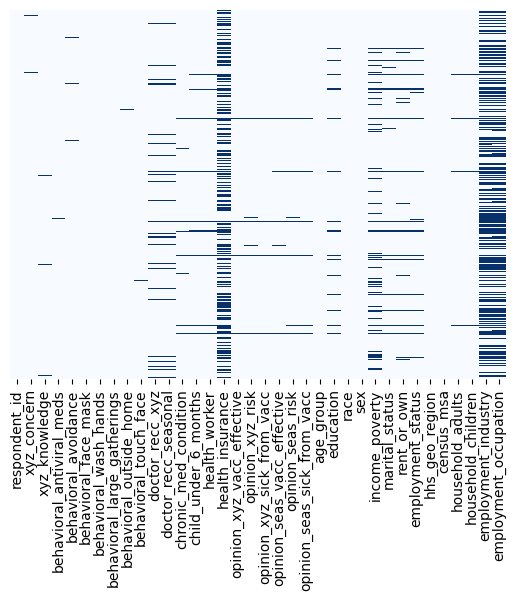

In [184]:
sns.heatmap(training_set_features.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=training_set_features.columns);
# gives an idea of missing values

In [185]:
sum(training_set_features.isna().sum(axis = 1)>0)   # the number of row entries having at least one missing entry


20270

In [186]:
sum(training_set_features.isna().sum(axis = 0)>0) # the number of cols having at least one missing entry

30

In [187]:
print(training_set_features)

       respondent_id  xyz_concern  xyz_knowledge  behavioral_antiviral_meds  \
0                  0          1.0            0.0                        0.0   
1                  1          3.0            2.0                        0.0   
2                  2          1.0            1.0                        0.0   
3                  3          1.0            1.0                        0.0   
4                  4          2.0            1.0                        0.0   
...              ...          ...            ...                        ...   
26702          26702          2.0            0.0                        0.0   
26703          26703          1.0            2.0                        0.0   
26704          26704          2.0            2.0                        0.0   
26705          26705          1.0            1.0                        0.0   
26706          26706          0.0            0.0                        0.0   

       behavioral_avoidance  behavioral_face_mask  

In [188]:
# from the above data we can see that heath_insurance, employment_industry and employement_occupation have a lot of null values
feature_cols = training_set_features.columns
cat_cols = [col for col in feature_cols if training_set_features[col].dtype == 'O'] # the cols are appended if the col has dtype 'object' - categorical
cont_cols = [col for col in feature_cols if col not in cat_cols] # the cols are appended if the col has int or float values - continuous

In [189]:
def encode_missing_columns(df, col):
    le = LabelEncoder() # this is a func of sklearn that is responsible for encoding categorical data a numerical value 
    
    # gets unique values w/o NaN
    unique_without_nan = pd.Series([i for i in df[col].unique() if type(i) == str])
    le.fit(unique_without_nan) # Fit on unique values
    
    # Set transformed col leaving np.NaN as they are
    df[col] = df[col].apply(lambda x: le.transform([x])[0] if type(x) == str else x)  # it encodes the value x if its a str

In [190]:
# imputing values using knn imputer - multivariate imputation
df_knn_imputer = training_set_features.copy()
for col in cat_cols:
    encode_missing_columns(df_knn_imputer, col)  # using the helper function to encode our categorical cols as knn does not support str

In [191]:
knn_imputer = KNNImputer(n_neighbors=5) #the knn imputer (k-nearest-neighbours has a parameter that decides how far to look for similarities)

df_knn_imputer[feature_cols] = knn_imputer.fit_transform(df_knn_imputer[feature_cols])

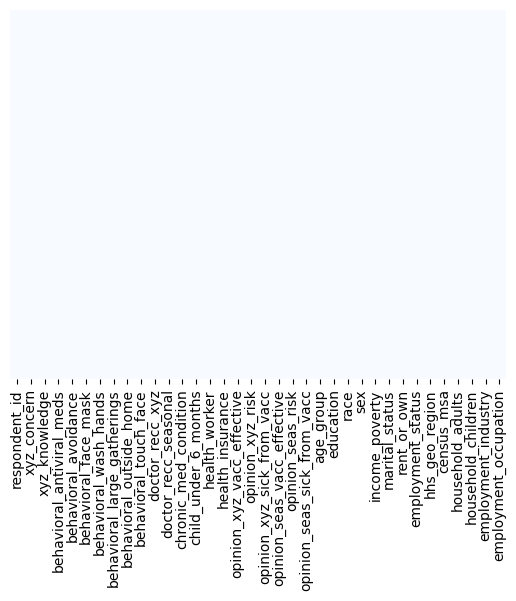

In [192]:
sns.heatmap(df_knn_imputer.isnull(), cmap='Blues', cbar=False, yticklabels=False, xticklabels=training_set_features.columns); 
# the hmap is empty as we have filled the NaN values with predicted data

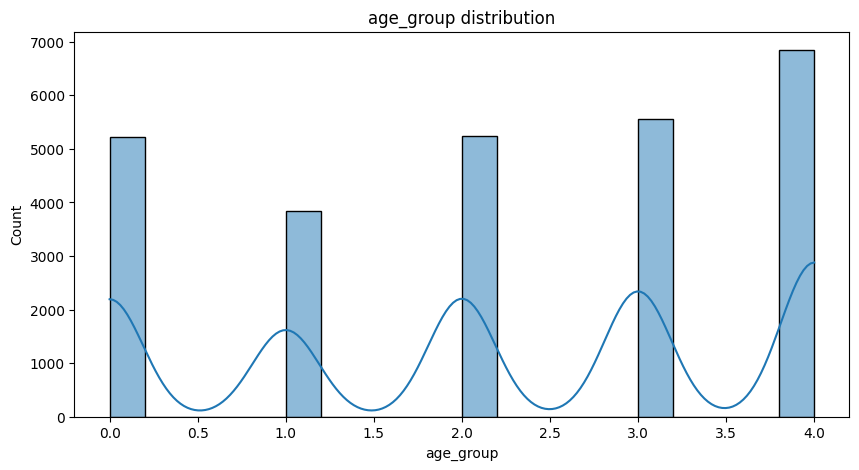

In [193]:
# plot singular features frequency distribution
def plot_feature_distribution(df, feature):
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} distribution')
    plt.show()

plot_feature_distribution(df_knn_imputer, 'age_group') # the age distribution


In [194]:
# code for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

X = df_knn_imputer
y = training_set_labels['xyz_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_norm, y_train)

y_pred = log_reg.predict(X_test_norm)

confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

#print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4212
           1       0.70      0.42      0.52      1130

    accuracy                           0.84      5342
   macro avg       0.78      0.68      0.71      5342
weighted avg       0.82      0.84      0.82      5342

0.6840718469774516


<h1>ROC-AUC Score</h1>
<p>The metrics when the entire dataset was fed as training and entire labels were used as prediction answers</p>

In [208]:
y2  = training_set_labels['seasonal_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_norm, y_train)

y_pred = log_reg.predict(X_test_norm)

confusion_matrix(y_test, y_pred)

#print(classification_report(y_test, y_pred))
#print(roc_auc_score(y_test, y_pred))

#print(X)

# publish probabilities to submission_format.csv for all respondant ids with respondant id, xyz vaccine and seasonal vaccine
submission_format = pd.read_csv('submission_format.csv')

norm = MinMaxScaler().fit(X)

# transform training data
X_norm = norm.transform(X)

# transform testing dataabs
X_test_norm = norm.transform(df_knn_imputer)

log_reg = LogisticRegression(max_iter=1000)
log_reg2 = LogisticRegression(max_iter=1000)
log_reg.fit(X_norm, y)
log_reg2.fit(X_norm, y2)

y_pred = log_reg.predict_proba(X_test_norm)
y_pred2 = log_reg2.predict_proba(X_test_norm)
# adjust the one row less
y1 = y_pred[:, 1]
y2 = y_pred2[:, 1]
y_pred = np.concatenate((y_pred, np.zeros((1, 2))), axis=0)
y_pred2 = np.concatenate((y_pred2, np.zeros((1, 2))), axis=0)

submission_format['respondent_id'] = test_set_features['respondent_id']

submission_format['h1n1_vaccine'] = y_pred[:, 1]
submission_format['seasonal_vaccine'] = y_pred2[:, 1]

# save to csv
submission_format.to_csv('submission.csv', index=False)
print(roc_auc_score(training_set_labels['xyz_vaccine'], y1))
print(roc_auc_score(training_set_labels['seasonal_vaccine'], y2))


0.830904516646475
0.8462536242271471


In [115]:
#code for naive bayes classifier 
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_norm, y_train)

y_pred = gnb.predict(X_test_norm)

confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2891
           1       0.72      0.72      0.72      2451

    accuracy                           0.74      5342
   macro avg       0.74      0.74      0.74      5342
weighted avg       0.74      0.74      0.74      5342

0.7396524985531006


In [116]:
# code for svm classifier
from sklearn.svm import SVC
svm = SVC()
y2 = training_set_labels['xyz_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

svm.fit(X_train_norm, y_train)

y_pred = svm.predict(X_test_norm)

print(roc_auc_score(y_test, y_pred))

0.6802082545445377
